In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [5]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations

,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-03-16,02,Alaska,8,1.124502
1,2,2024-03-16,01,Alabama,81,1.599596
2,3,2024-03-16,05,Arkansas,188,6.180393
3,4,2024-03-16,04,Arizona,134,1.825360
4,5,2024-03-16,06,California,185,0.475743
...,...,...,...,...,...,...
5825,5826,2022-02-12,50,Vermont,0,0.000000
5826,5827,2022-02-12,53,Washington,8,0.103415
5827,5828,2022-02-12,55,Wisconsin,29,0.492275
5828,5829,2022-02-12,54,West Virginia,5,0.281694


In [7]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


In [8]:
predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    print(model, len(df.location.unique()))
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


In [9]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

In [10]:
predictions_traj

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
0,2023-09-03 00:00:00,B-2023-08-14,inc hosp,1.0,06,sample,1,0-130,48.000000,CADPH-FluCAT,2023-09-09
1,2023-09-03 00:00:00,B-2023-08-14,inc hosp,2.0,06,sample,1,0-130,45.000000,CADPH-FluCAT,2023-09-16
2,2023-09-03 00:00:00,B-2023-08-14,inc hosp,3.0,06,sample,1,0-130,86.000000,CADPH-FluCAT,2023-09-23
3,2023-09-03 00:00:00,B-2023-08-14,inc hosp,4.0,06,sample,1,0-130,109.000000,CADPH-FluCAT,2023-09-30
4,2023-09-03 00:00:00,B-2023-08-14,inc hosp,5.0,06,sample,1,0-130,187.000000,CADPH-FluCAT,2023-10-07
...,...,...,...,...,...,...,...,...,...,...,...
16795,2023-09-03,F-2023-08-14,inc hosp,28.0,US,sample,96,0-130,937.881800,UVA-FluXSim,2024-03-16
16796,2023-09-03,F-2023-08-14,inc hosp,28.0,US,sample,97,0-130,491.298401,UVA-FluXSim,2024-03-16
16797,2023-09-03,F-2023-08-14,inc hosp,28.0,US,sample,98,0-130,889.442877,UVA-FluXSim,2024-03-16
16798,2023-09-03,F-2023-08-14,inc hosp,28.0,US,sample,99,0-130,613.492689,UVA-FluXSim,2024-03-16


In [28]:

# only look at MOBS trajectories and for scenario F

predictions_mobs = predictions_traj[(predictions_traj.Model == 'MOBS_NEU-GLEAM_FLU') ]

In [12]:
predictions_mobs

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
1267500,2023-09-03,F-2023-08-14,inc hosp,1.0,01,sample,1.0,0-130,11.000,MOBS_NEU-GLEAM_FLU,2023-09-09
1267501,2023-09-03,F-2023-08-14,inc hosp,2.0,01,sample,1.0,0-130,30.000,MOBS_NEU-GLEAM_FLU,2023-09-16
1267502,2023-09-03,F-2023-08-14,inc hosp,3.0,01,sample,1.0,0-130,25.783,MOBS_NEU-GLEAM_FLU,2023-09-23
1267503,2023-09-03,F-2023-08-14,inc hosp,4.0,01,sample,1.0,0-130,39.517,MOBS_NEU-GLEAM_FLU,2023-09-30
1267504,2023-09-03,F-2023-08-14,inc hosp,5.0,01,sample,1.0,0-130,41.340,MOBS_NEU-GLEAM_FLU,2023-10-07
...,...,...,...,...,...,...,...,...,...,...,...
1470284,2023-09-03,F-2023-08-14,inc hosp,24.0,US,sample,100.0,0-130,3691.810,MOBS_NEU-GLEAM_FLU,2024-02-17
1470285,2023-09-03,F-2023-08-14,inc hosp,25.0,US,sample,100.0,0-130,3749.501,MOBS_NEU-GLEAM_FLU,2024-02-24
1470286,2023-09-03,F-2023-08-14,inc hosp,26.0,US,sample,100.0,0-130,4279.784,MOBS_NEU-GLEAM_FLU,2024-03-02
1470287,2023-09-03,F-2023-08-14,inc hosp,27.0,US,sample,100.0,0-130,4552.643,MOBS_NEU-GLEAM_FLU,2024-03-09


In [29]:
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

energyscoresdf = pd.DataFrame()


predictions_mobs['target_end_date'] = pd.to_datetime(predictions_mobs['target_end_date'])


for date in predictions_mobs.target_end_date.unique():
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        for loc in predictions_mobs.location.unique():

            if loc in ['60','66','69', '72', '78']:
                continue



            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs


            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_mobs[(predictions_mobs.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_mobs.location == loc) & \
                                        (predictions_mobs.target_end_date == date) ]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue

            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   


            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = normalized_energyscore(np.array(X),y)


            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':'MOBS_NEU-GLEAM_FLU','location':loc_conv, 'energyscore':ES, 'week':date,
                                'target':target, 'Label':'Scenario '+scenario}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [20]:
energyscoresdf

,Model,location,energyscore,week,target
0,MOBS_NEU-GLEAM_FLU,1,3.842780,2023-09-09,hosp
1,MOBS_NEU-GLEAM_FLU,2,3.991180,2023-09-09,hosp
2,MOBS_NEU-GLEAM_FLU,4,3.934407,2023-09-09,hosp
3,MOBS_NEU-GLEAM_FLU,5,3.687711,2023-09-09,hosp
4,MOBS_NEU-GLEAM_FLU,6,3.710108,2023-09-09,hosp
...,...,...,...,...,...
1451,MOBS_NEU-GLEAM_FLU,53,17.207557,2024-03-16,hosp
1452,MOBS_NEU-GLEAM_FLU,54,8.294532,2024-03-16,hosp
1453,MOBS_NEU-GLEAM_FLU,55,NaN,2024-03-16,hosp
1454,MOBS_NEU-GLEAM_FLU,56,NaN,2024-03-16,hosp


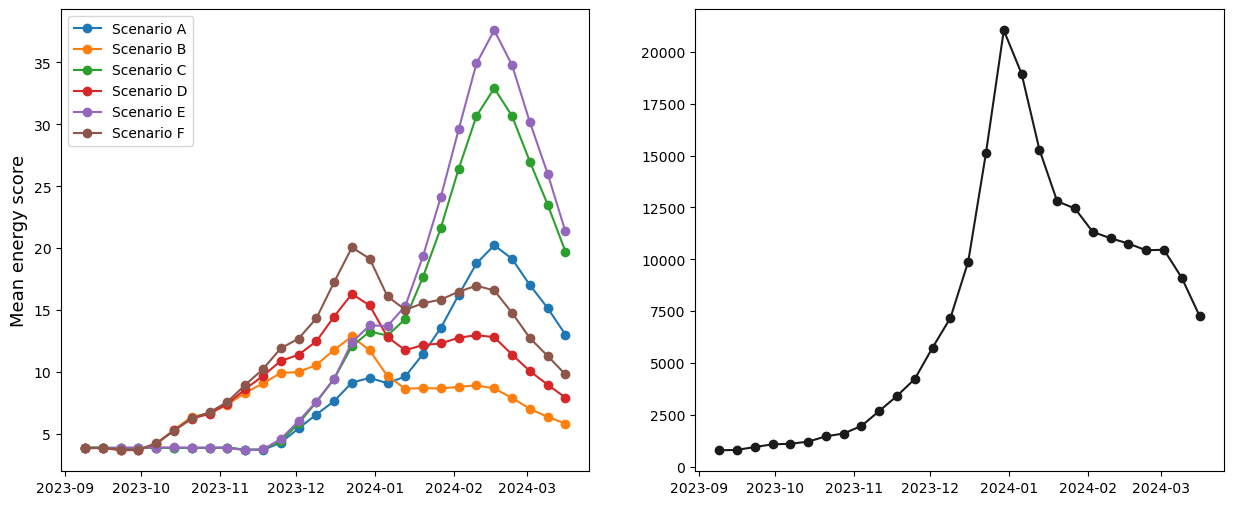

In [46]:
groups = energyscoresdf.groupby('Label')
plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
for name, group in groups:
    plt.plot(pd.DataFrame(group.groupby('week').mean()['energyscore']), '-o', label=name)

plt.ylabel('Mean energy score', fontsize=13)
plt.legend()

plt.subplot(1,2,2)

observations = format_observations(location='US')
plt.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')


In [39]:
# look at same for WIS

wisdf_timestamp = pd.read_pickle('wis_timestamp_rd4.pkl')

#calculate WIS normalized by standard deviation

wisdfstd = pd.DataFrame()
for loc in wisdf_timestamp.location.unique():
    for label in wisdf_timestamp.Label.unique():  
        for date in wisdf_timestamp.date.unique():
            dffilt = wisdf_timestamp[(wisdf_timestamp.location == loc) & (wisdf_timestamp.Label == label) & \
                                     (wisdf_timestamp.date == date) ]

            stdev = dffilt['WIS'].std()
                
            dffilt['WISscale'] = dffilt['WIS'] / stdev

            
            wisdfstd = pd.concat([wisdfstd, dffilt])


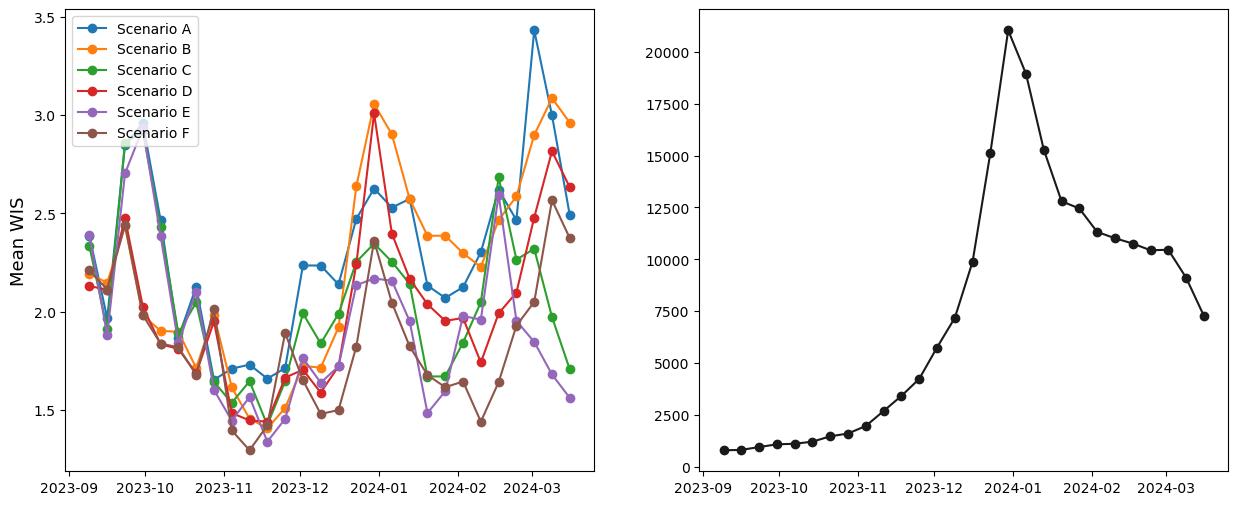

In [48]:
wisdf = wisdfstd[wisdfstd.Model == 'MOBS_NEU-GLEAM_FLU']

groups = wisdf.groupby('Label')
plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
for name, group in groups:
    plt.plot(pd.DataFrame(group.groupby('date').mean()['WISscale']), '-o', label=name)

plt.ylabel('Mean WIS', fontsize=13)
plt.legend(loc='upper left')

plt.subplot(1,2,2)

observations = format_observations(location='US')
plt.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')


In [ ]:
# 